# Importing Libraries

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image


# Data conversion to Faster RCNN format

In [2]:
class RoadSignDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None, class_map=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
        self.class_map = class_map if class_map else {0: "traffic_sign"}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        image_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, image_name)
        img = Image.open(img_path).convert("RGB")
        img_width, img_height = img.size

        # Load corresponding label
        label_path = os.path.join(self.labels_dir, image_name.replace(".jpg", ".txt").replace(".png", ".txt"))
        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())
                    
                    # Convert from YOLO to Pascal VOC
                    x_min = (x_center - width / 2) * img_width
                    y_min = (y_center - height / 2) * img_height
                    x_max = (x_center + width / 2) * img_width
                    y_max = (y_center + height / 2) * img_height

                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(int(class_id))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Target dictionary required by Faster R-CNN
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        # Apply transforms if any
        if self.transforms:
            img = self.transforms(img)

        return img, target


In [3]:
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Define transforms for Faster R-CNN
transform = ToTensor()

# Dataset paths
train_dataset = RoadSignDataset(
    images_dir='Dataset/train/images',
    labels_dir='Dataset/train/labels',
    transforms=transform
)

val_dataset = RoadSignDataset(
    images_dir='Dataset/val/images',
    labels_dir='Dataset/val/labels',
    transforms=transform
)

test_dataset = RoadSignDataset(
    images_dir='Dataset/test/images',
    labels_dir='Dataset/test/labels',
    transforms=transform
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


# Loading Faster RCNN

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load a Faster R-CNN model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier with a new one for 4 classes (including background as class 0)
num_classes = 5  # 4 road sign classes + 1 background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move to GPU if available
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

print("✅ Faster R-CNN loaded and customized.")


c:\Users\LAB.LAB12-PC42\Desktop\Road-Sign-Detection\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LAB.LAB12-PC42\Desktop\Road-Sign-Detection\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\LAB.LAB12-PC42/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:02<00:00, 56.3MB/s] 


✅ Faster R-CNN loaded and customized.


# Training function for RCNN

In [5]:
import torch
import time
from torch.utils.data import DataLoader

def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    epoch_loss = 0
    start = time.time()

    for images, targets in dataloader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        # Backward + Optimize
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    end = time.time()
    print(f"⏱️ Epoch completed in {(end - start):.2f} seconds - Loss: {epoch_loss:.4f}")
    return epoch_loss


# Training Loop

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
import torch

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier head
num_classes = 5  # 4 classes + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move model to GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, device)

# ✅ Save the model after training
torch.save(model.state_dict(), "fasterrcnn_road_signs.pth")
print("\n✅ Model saved as 'fasterrcnn_road_signs.pth'")



🔁 Epoch 1/5
⏱️ Epoch completed in 81.94 seconds - Loss: 27.3800

🔁 Epoch 2/5
⏱️ Epoch completed in 84.70 seconds - Loss: 11.0962

🔁 Epoch 3/5
⏱️ Epoch completed in 83.14 seconds - Loss: 8.5666

🔁 Epoch 4/5
⏱️ Epoch completed in 82.21 seconds - Loss: 7.2880

🔁 Epoch 5/5
⏱️ Epoch completed in 81.05 seconds - Loss: 6.7948

✅ Model saved as 'fasterrcnn_road_signs.pth'


# Loading the trained model

In [9]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Number of classes (4 classes + background)
num_classes = 5

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

# Replace the classifier head for your dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load trained weights
model.load_state_dict(torch.load("fasterrcnn_road_signs.pth"))

# Move model to GPU and set to eval mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


c:\Users\LAB.LAB12-PC42\Desktop\Road-Sign-Detection\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LAB.LAB12-PC42\Desktop\Road-Sign-Detection\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\LAB.LAB12-PC42/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 70.8MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

# Running on test set

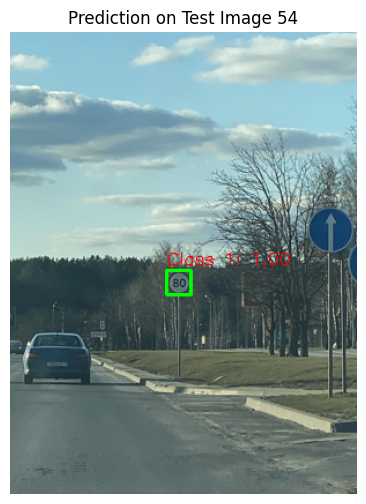

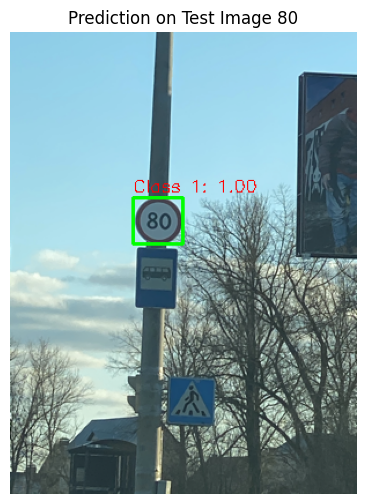

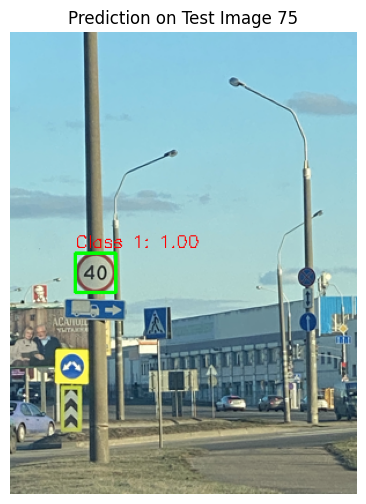

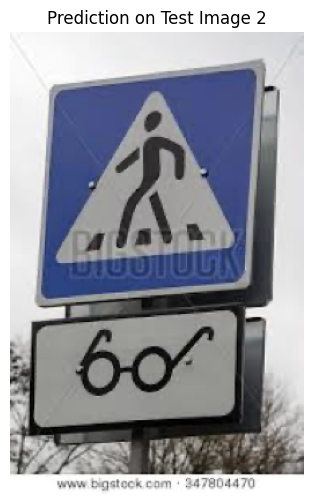

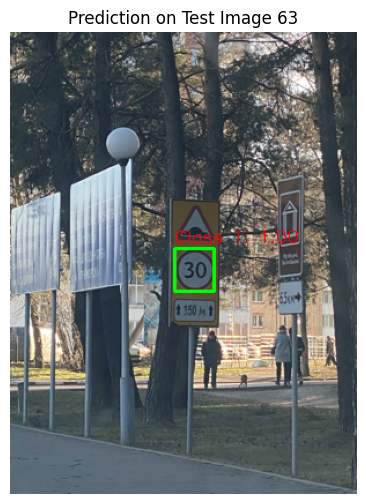

In [10]:
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
from torchvision.transforms import functional as F

# Pick 5 random images from the test set
num_samples = 5
indices = random.sample(range(len(test_dataset)), num_samples)

# Set confidence threshold for display
confidence_threshold = 0.5

# Plot predictions
for idx in indices:
    image, target = test_dataset[idx]
    image_gpu = image.to(device)
    with torch.no_grad():
        prediction = model([image_gpu])[0]

    # Convert image tensor to NumPy for visualization
    img_np = F.to_pil_image(image).convert("RGB")
    img_np = np.array(img_np)

    # Draw boxes
    for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
        if score >= confidence_threshold:
            x1, y1, x2, y2 = box.int().cpu().numpy()
            cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_np, f"Class {label}: {score:.2f}", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Display
    plt.figure(figsize=(8, 6))
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"Prediction on Test Image {idx}")
    plt.show()


# Model Evalutaion

In [14]:
import os
import cv2
import torch
import torchvision.transforms as T
from torchvision.ops import box_iou
from tqdm import tqdm

# Path to test images and labels
test_img_dir = 'Dataset/test/images'
test_lbl_dir = 'Dataset/test/labels'

# Transformation
transform = T.Compose([T.ToTensor()])

# COCO-style evaluator (simplified)
def evaluate_faster_rcnn(model, img_dir, lbl_dir, device, iou_threshold=0.5):
    model.eval()
    tp, fp, fn = 0, 0, 0

    img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]

    for img_file in tqdm(img_files, desc="Evaluating"):
        img_path = os.path.join(img_dir, img_file)
        label_path = os.path.join(lbl_dir, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))

        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = transform(img_rgb).to(device)

        # Run inference
        with torch.no_grad():
            preds = model([img_tensor])[0]

        pred_boxes = preds['boxes'].cpu()
        scores = preds['scores'].cpu()
        pred_boxes = pred_boxes[scores > 0.5]  # Confidence threshold

        # Load GT boxes
        gt_boxes = []
        if os.path.exists(label_path):
            h, w, _ = img.shape
            with open(label_path, 'r') as f:
                for line in f:
                    cls_id, x, y, bw, bh = map(float, line.strip().split())
                    x1 = (x - bw / 2) * w
                    y1 = (y - bh / 2) * h
                    x2 = (x + bw / 2) * w
                    y2 = (y + bh / 2) * h
                    gt_boxes.append([x1, y1, x2, y2])
        gt_boxes = torch.tensor(gt_boxes)

        if len(pred_boxes) == 0:
            fn += len(gt_boxes)
            continue
        if len(gt_boxes) == 0:
            fp += len(pred_boxes)
            continue

        ious = box_iou(pred_boxes, gt_boxes)
        max_ious, _ = ious.max(dim=1)

        tp += (max_ious > iou_threshold).sum().item()
        fp += (max_ious <= iou_threshold).sum().item()
        fn += max(0, len(gt_boxes) - (max_ious > iou_threshold).sum().item())

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    print(f"\n📊 Test Set Evaluation:")
    print(f"✔️ Precision: {precision:.4f}")
    print(f"✔️ Recall:    {recall:.4f}")
    print(f"✔️ F1 Score:  {f1:.4f}")

# Evaluate your loaded model
evaluate_faster_rcnn(model, test_img_dir, test_lbl_dir, device)


Evaluating: 100%|██████████| 89/89 [00:04<00:00, 17.98it/s]


📊 Test Set Evaluation:
✔️ Precision: 0.9722
✔️ Recall:    0.7836
✔️ F1 Score:  0.8678


In [15]:
# We can improve the recallby increasing the image size, training for more epochs, trying data augmentation, and finally fine tuning the optimizer